# <span style="color:green">Evaluation of Satellite Imagery Inputs Used to Create a "Fused" Land Surface Temperature product</span>
Erik Anderson & Tyler Cruickshank

# <span style="color:green">Project Overview</span>

Maximizing agricultural productivity is critical for maintaining world food supply and controlling food cost. Modern agribusiness employs targeted technology to optimize cropland productivity using modern information and communication technologies at fine spatial resolution (within-field scale). 

[Hyrdrosat](https://www.hydrosat.com/) is a value-added satellite data provider whose mission is to provide real-time thermal infrared data to customers in the agribusiness and government sectors. Thermal infrared data can be used to  inform adaptive irrigation  and  predict crop yields . 

Until the upcoming launch of its own 16-satellite constellation, Hydrosat produces estimates of land surface temperature using thermal infrared data from a combination of MODIS, Sentinel and Landsat imaging platforms. Available data suffers from low spatial and temporal resolutions. Hydrosat utilizes an implementation of the data mining approach for sharpening thermal satellite imagery (DMS; as described in Gao 2012) and a separate algorithm for interpolating land surface temperature between acquisition windows (STARFM; as described in Gao 2006), to produce a proprietry "Fused" Land Surface Temperature (LST) imagery product resulting in a near daily estimate of LST at sub-30 meter resolution. 

The Fused LST product and its inputs are accessed from a Spatial Temporal Asset Catalog (STAC). STAC is a specification standard with a unified language to describe geospatial data which allows it to be more easily searchable and queryable. Data are served through the [Hydrosat's Fusion Hub](https://hydrosat.github.io/fusion-hub-docs/intro.html). (Credentials for data access must be requested as directed on the Fusion Hub homepage.) 

This project aims to explore the input data and intermediate outputs of the algorithms used to produce the LST product in order to evaluate the potential usefulness of the Fused LST product for detecting crop stress within agricultural contexts. 

In [1]:
# Import standard libraries
import base64
import json
import os
os.environ['USE_PYGEOS'] = '0'
import yaml

# Import installed libraries
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from odc.stac import stac_load
import pandas as pd
from pyproj.crs import CRS
from pystac_client import Client
import seaborn as sns
from shapely.geometry import Point, Polygon
import warnings
import xarray as xr

# Import local modules
from library import utils
from library.FH_Hydrosat import FH_Hydrosat

# Read configuration file
with open("config.yml","r") as f:
    config = yaml.safe_load(f)

# Set matplotlib params
plt.rcParams["font.family"] = "Calibri"

# Hide warnings
warnings.filterwarnings('ignore')


In [2]:
# Specify crop type for each finding 
f1_met_tower = 'alfalfa'
f2_met_tower = 'corn'

# Set start and end dates for assessment
start_date = "2022-04-01T00:00:00Z"
end_date = "2022-08-31T00:00:00Z"

In [3]:
# Create geometries for primary agricultural field
geom = {
    'type': 'Point', 
    'coordinates': config[f1_met_tower]['field_center']
}
f1_met_tower_pt = Point(config[f1_met_tower]['metpoint'])
f1_pt = Point(geom['coordinates'])
f1_poly = Polygon(config[f1_met_tower]['aoi_coordinates'])
f1_poly_gdf = gpd.GeoDataFrame(
    {'geometry':[f1_poly]}, crs=CRS.from_epsg(4326))
f1_poly_gdf = f1_poly_gdf.to_crs(crs = CRS.from_epsg(32610))
f1_poly_gdf_buffer = f1_poly_gdf.buffer(1000)

# Create geometries for secondary agricultural field
geom = {
    'type': 'Point', 
    'coordinates': config[f2_met_tower]['field_center']
}
f2_met_tower_pt = Point(config[f2_met_tower]['metpoint'])
f2_pt = Point(geom['coordinates'])
f2_poly = Polygon(config[f2_met_tower]['aoi_coordinates'])
f2_poly_gdf = gpd.GeoDataFrame(
    {'geometry':[f2_poly]}, crs=CRS.from_epsg(4326))
f2_poly_gdf = f2_poly_gdf.to_crs(crs = CRS.from_epsg(32610))
f2_poly_gdf_buffer = f2_poly_gdf.buffer(1000)

# <span style="color:green">Project Location</span>

The project is focused on agricultural areas with active farming in the San Joaquin Valley of California, United States. An alfalfa field and a corn field were both assessed for the 2022 growing season.

In [4]:
# Create map
m = folium.Map(tiles='Stamen Terrain')

# Add ESRI imagery tile layer
esri_imagery_url = 'https://server.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}'
esri_imagery_layer = folium.TileLayer(tiles=esri_imagery_url, attr='ESRI Imagery', name='ESRI Imagery', overlay=False)
esri_imagery_layer.add_to(m)

# Map the geometeries for field 1
marker1 = folium.Marker(
    location=[f1_pt.coords[0][1], f1_pt.coords[0][0]],
    icon=folium.Icon(color='black', icon='glyphicon glyphicon-record'),
    popup=f'{f1_met_tower} Field Center'
)
marker1.add_to(m)

met_tower_loc1 = folium.Marker(
    location=[f1_met_tower_pt.coords[0][1], f1_met_tower_pt.coords[0][0]],
    icon=folium.Icon(color='green', icon='glyphicon glyphicon-flag'),
    popup=f'{f1_met_tower} Met Tower'
)
met_tower_loc1.add_to(m)

field1 = folium.GeoJson(
    f1_poly.__geo_interface__,
    name=f"{f1_met_tower} Field Boundary",
    style_function=lambda x: {
        'color': 'black',
        'fillColor': None,
        'fillOpacity': 0,
        'weight': 1     
    }
)
field1.add_to(m)

assess_boundary1 = folium.GeoJson(
    f1_poly_gdf_buffer.to_crs(4326).__geo_interface__,
    name=f"{f1_met_tower} Assessment Area",
    style_function=lambda x: {
        'color': 'red',
        'fillColor': None,
        'fillOpacity': 0,
        'weight': 2     
    }
)
assess_boundary1.add_to(m)

# Map the geometeries for field 2
marker2 = folium.Marker(
    location=[f2_pt.coords[0][1], f2_pt.coords[0][0]],
    icon=folium.Icon(color='black', icon='glyphicon glyphicon-record'),
    popup=f'{f2_met_tower} Field Center'
)
marker2.add_to(m)

met_tower_loc2 = folium.Marker(
    location=[f2_met_tower_pt.coords[0][1], f2_met_tower_pt.coords[0][0]],
    icon=folium.Icon(color='green', icon='glyphicon glyphicon-flag'),
    popup=f'{f2_met_tower} Met Tower'
)
met_tower_loc2.add_to(m)

field2 = folium.GeoJson(
    f2_poly.__geo_interface__,
    name=f"{f2_met_tower} Field Boundary",
    style_function=lambda x: {
        'color': 'black',
        'fillColor': None,
        'fillOpacity': 0,
        'weight': 1     
    }
)
field2.add_to(m)

assess_boundary2 = folium.GeoJson(
    f2_poly_gdf_buffer.to_crs(4326).__geo_interface__,
    name=f"{f2_met_tower} Assessment Area",
    style_function=lambda x: {
        'color': 'red',
        'fillColor': None,
        'fillOpacity': 0,
        'weight': 2     
    }
)
assess_boundary2.add_to(m)

# Add layer control
layer_control = folium.LayerControl()
layer_control.add_to(m)


# Adjust the map view
m.fit_bounds(m.get_bounds())

m

<p style="font-size: .9rem"><b>Figure 1</b> | This map visualizes the project area assessed. The red boundary illustrates the clip area for imagery. The black polygon displays the field boundaries for the agricultural field evaluated. The black marker shows the field center and is the location from which imagery will be sampled when calculating key metrics. The green marker shows the location of the meteorological tower.</p>

# <span style="color:green">Findings</span>

Our work revealed two important findings for Hydrosat's Fused Land Surface Temperature Product:
1. The short-term vegetation signal is muted by compositing surface reflectance
2. The Fused LST product provides a leading indicator of crop stress

Each finding is discussed in detail below.

## <span style="color:green">The short-term vegetation signal is muted by compositing surface reflectance</span>

When compositing Sentinel-2 and Landsat imagery, the current implementation of the STARFM algorithm to interpolate between acquisition windows tends to suppress the vegetation signal. In the current implementation, the median pixel value is calculated for the period two weeks before and two weeks after the interpolated value. This moving window approach reduces the sensitivity of the resulting data to short term fluctuations in crop stress.

To illustrate, we compare the Normalized Difference Vegetation Index (NDVI) as calculated by the meterological tower, Senitnel 2 data, and the composites for Sentinel 2 and MODIS. NDVI is a commonly used remotely sensed index that provides data on the "greenness" or health of crop vegetation. 

In [5]:
# Define paths to data
data_dir = os.path.join('data', 'Ameriflux')
file_name = config[f1_met_tower]['data_params']['file_name']
file_path = os.path.join(data_dir, file_name)

# Read data
met_df = utils.read_ameriflux(file_path)

# Filter meteorological data by dates
filt = (
    (met_df.index > start_date) & (met_df.index < end_date)
)
met_df = met_df.loc[filt]


In [6]:
# Authenticate and access catalog
with open(os.path.join('secrets', 'creds.json')) as f:
    creds = json.loads(f.read())
    
userpass = f"{creds['username']}:{creds['password']}"
b64 = base64.b64encode(userpass.encode()).decode()
headers = {'Authorization':'Basic ' + b64}

cat_url = 'https://fusion-stac.hydrosat.com'
catalog = Client.open(cat_url, headers)

In [7]:
# Connect to Sentinel 2 collection
eurl = "https://earth-search.aws.element84.com/v1/"
s2coll = "sentinel-2-l2a"
aoi = f1_pt
clip_boundary = f1_poly_gdf_buffer

s2_cat = Client.open(eurl)
s2_search = s2_cat.search(
    collections=s2coll,
    intersects=aoi,
    datetime=[start_date, end_date],
    max_items=1000
)

ds_s2_odc = stac_load(
    s2_search.item_collection(),
    bands=["red", "green", "blue", "nir08"],
    chunks={"x": 1024, "y": 1024},
    groupby="solar_day",
    resolution=20,
)

In [8]:
# Drop clouded images from data array
ds_s2_odc_qa = ds_s2_odc.drop_sel(
    time=['2022-04-14T19:03:54.654000000',
          '2022-04-19T19:03:46.966000000',
          '2022-07-03T19:04:04.671000000',
          '2022-08-17T19:03:53.828000000',
          '2022-07-28T19:03:56.581000000']
)

In [9]:
# Connect to Sentinel 2 composite collection
collection = 'prepped_inputs_s2'
asset = 'surface_reflectance'

s2_comp_items = utils.connect_to_collection(
    catalog, aoi, collection, start_date, end_date)
# Read items in Sentinel 2 collection in the assessment area
s2_comp_clip = utils.read_and_clip_items(
    s2_comp_items, asset, clip_boundary)

In [10]:
# Connect to MODIS composite collection
collection = 'prepped_inputs_mcd43a4'
asset = 'surface_reflectance'

modis_comp_items = utils.connect_to_collection(
    catalog, aoi, collection, start_date, end_date)
# Read items in MODIS collection in the assessment area
modis_comp_clip = utils.read_and_clip_items(
    modis_comp_items, asset, clip_boundary)

In [11]:
# Connect to Fused Land Surface Temperature collection
collection = 'starfm_predictions_modis_landsat'
asset = 'lst'

lst_items = utils.connect_to_collection(
    catalog, aoi, collection, start_date, end_date)
# Read items in LST collection in the assessment area
lst_clip = utils.read_and_clip_items(
    lst_items, asset, clip_boundary, dims=("y", "x"))

In [12]:
# Define function to normalize RGB data for plotting
def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

In [13]:
# Clip Sentinel 2 to area of interest
s2_nir_clip = ds_s2_odc_qa['nir08'].rio.clip(
    clip_boundary.geometry, all_touched=True, drop=True)
s2_red_clip = ds_s2_odc_qa['red'].rio.clip(
    clip_boundary.geometry, all_touched=True, drop=True)
s2_green_clip = ds_s2_odc_qa['green'].rio.clip(
    clip_boundary.geometry, all_touched=True, drop=True)
s2_blue_clip = ds_s2_odc_qa['blue'].rio.clip(
    clip_boundary.geometry, all_touched=True, drop=True)

# Combine all bands
s2_concat = xr.concat([s2_blue_clip, 
                       s2_green_clip, 
                       s2_red_clip, 
                       s2_nir_clip], dim='band')

# Correct for processing baseline v 4.0.0
s2_cor = (s2_concat-0.1)*0.0001

In [14]:
# Create RGB from Sentinel-2 data
s2_rgb_bands = [2,1,0]
s2_rgb = normalize(s2_cor.isel(band=s2_rgb_bands))

In [15]:
# Define NDVI function
def calc_ndvi(ds, red_band, nir_band):
    red = ds.sel(band=red_band)
    nir = ds.sel(band=nir_band)
    ndvi = (nir - red) / (nir + red)
    return ndvi

In [16]:
# Create NDVI from Sentinel-2 data
s2_ndvi = calc_ndvi(s2_cor, red_band=2, nir_band=3)

# Create NDVI from Sentinel-2 composite data
s2c_ndvi = calc_ndvi(s2_comp_clip, red_band=2, nir_band=6)
s2c_ndvi = s2c_ndvi.rio.set_crs(CRS.from_epsg(32610))

In [17]:
# Filter meteorological data by valid NDVI and dates
try:
    filt = (
        (met_df['NDVI'] > 0.25) & (met_df['NDVI'] < 0.75) 
    )
    met_ndvi = met_df.loc[filt, 'NDVI']
except(KeyError):
    print('Warning! NDVI is not available in the meteorological data')

In [18]:
# Clip NDVI from imagery to field boundary
s2_ndvi_field = s2_ndvi.rio.clip(
    f1_poly_gdf.geometry, all_touched=True, drop=True)
s2c_ndvi_field = s2c_ndvi.rio.clip(
    f1_poly_gdf.geometry, all_touched=True, drop=True)

In [19]:
# Extract the time series of NDVI for MODIS using FH_Hydrosat
assets = modis_comp_items[0].to_dict()['assets'].keys()
if len(modis_comp_items) > 0 and 'surface_reflectance' in assets:
    res_full = FH_Hydrosat(modis_comp_items, asset='surface_reflectance')
    res_dt = res_full.datetime
    tolerance = 750
    red_band = 0
    nir_band = 1

    red_ts = res_full.point_time_series_from_items(
        f1_pt, tol=tolerance, nproc=6, band=red_band)
    nir_ts = res_full.point_time_series_from_items(
        f1_pt, tol=tolerance, nproc=6, band=nir_band)

    ndvi_ts = ((np.array(nir_ts) - np.array(red_ts)) 
    / (np.array(nir_ts) + np.array(red_ts)))
    ndvi_dt = res_dt

    ndvi_df = pd.DataFrame(
        {'ndvi': ndvi_ts,
        'datetime': pd.to_datetime(ndvi_dt)}).sort_values(by='datetime')
    ndvi_df.index = pd.to_datetime(
        ndvi_df['datetime'].dt.strftime('%Y-%m-%d'))

    modis_ndvi = ndvi_df['ndvi'].astype('float')
    modis_ndvi.name = 'modis_comp'

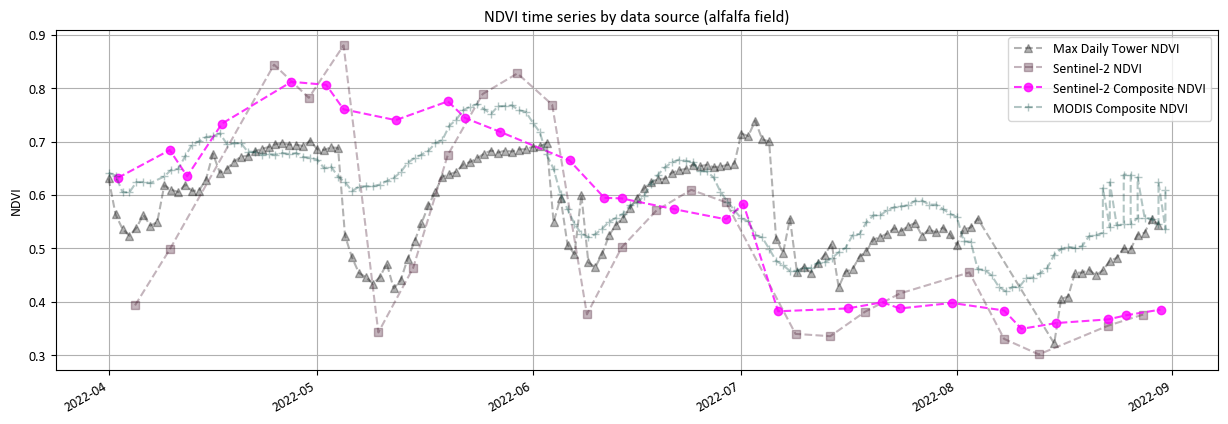

In [20]:
# Plot all NDVI series
fig, ax = plt.subplots(figsize=(15,5))

try:
    met_ndvi.groupby(met_ndvi.index.date).max().plot(
        linestyle='--', alpha=0.3, marker='^', c='k', 
        label='Max Daily Tower NDVI')
except:
    pass

s2_ndvi_field.mean(dim=('x', 'y')).plot(
    linestyle='--', alpha=0.3, marker='s', c='#3b0921', 
    label='Sentinel-2 NDVI')
s2c_ndvi_field.mean(dim=('x', 'y')).plot(
    linestyle='--', alpha=0.8, marker='o', c='#ff00ff', 
    label='Sentinel-2 Composite NDVI')
modis_ndvi.plot(
    linestyle='--', alpha=0.3, marker='+', c='#00423c', 
    label='MODIS Composite NDVI')

plt.title(f"NDVI time series by data source ({f1_met_tower} field)")
plt.ylabel("NDVI")
plt.xlabel("")
plt.grid(True)
plt.legend()
plt.show()

<p style="font-size: .9rem"><b>Figure 2</b> | NDVI is plotted over the growing season for the year 2022 in this alfalfa field. The in-situ meteorological tower provides a benchmark for expected NDVI values. Both Sentinel-2 and the MODIS composite NDVI values are consistent with the periodicity of the benchmark. However, the Sentinel-2 composite reflects only the general trend towards lower NDVI across the entire growing season and does not capture the periodicity of the benchmark.</p>

We can observe this effect more directly by comparing the true color imagery from Sentinel-2 and the composite Sentinel-2 data. The first panel shows the original Sentinel-2 true color imagery and the second panel shows the composite Sentinel-2 imagery.

In [21]:
# Create RGB from Sentinel-2 data
s2_rgb_bands = [2,1,0]
s2_rgb = normalize(s2_cor.isel(band=s2_rgb_bands))

# Create RGB from Sentinel-2 composite data
s2_comp_rgb = normalize(s2_comp_clip.isel(band=s2_rgb_bands))

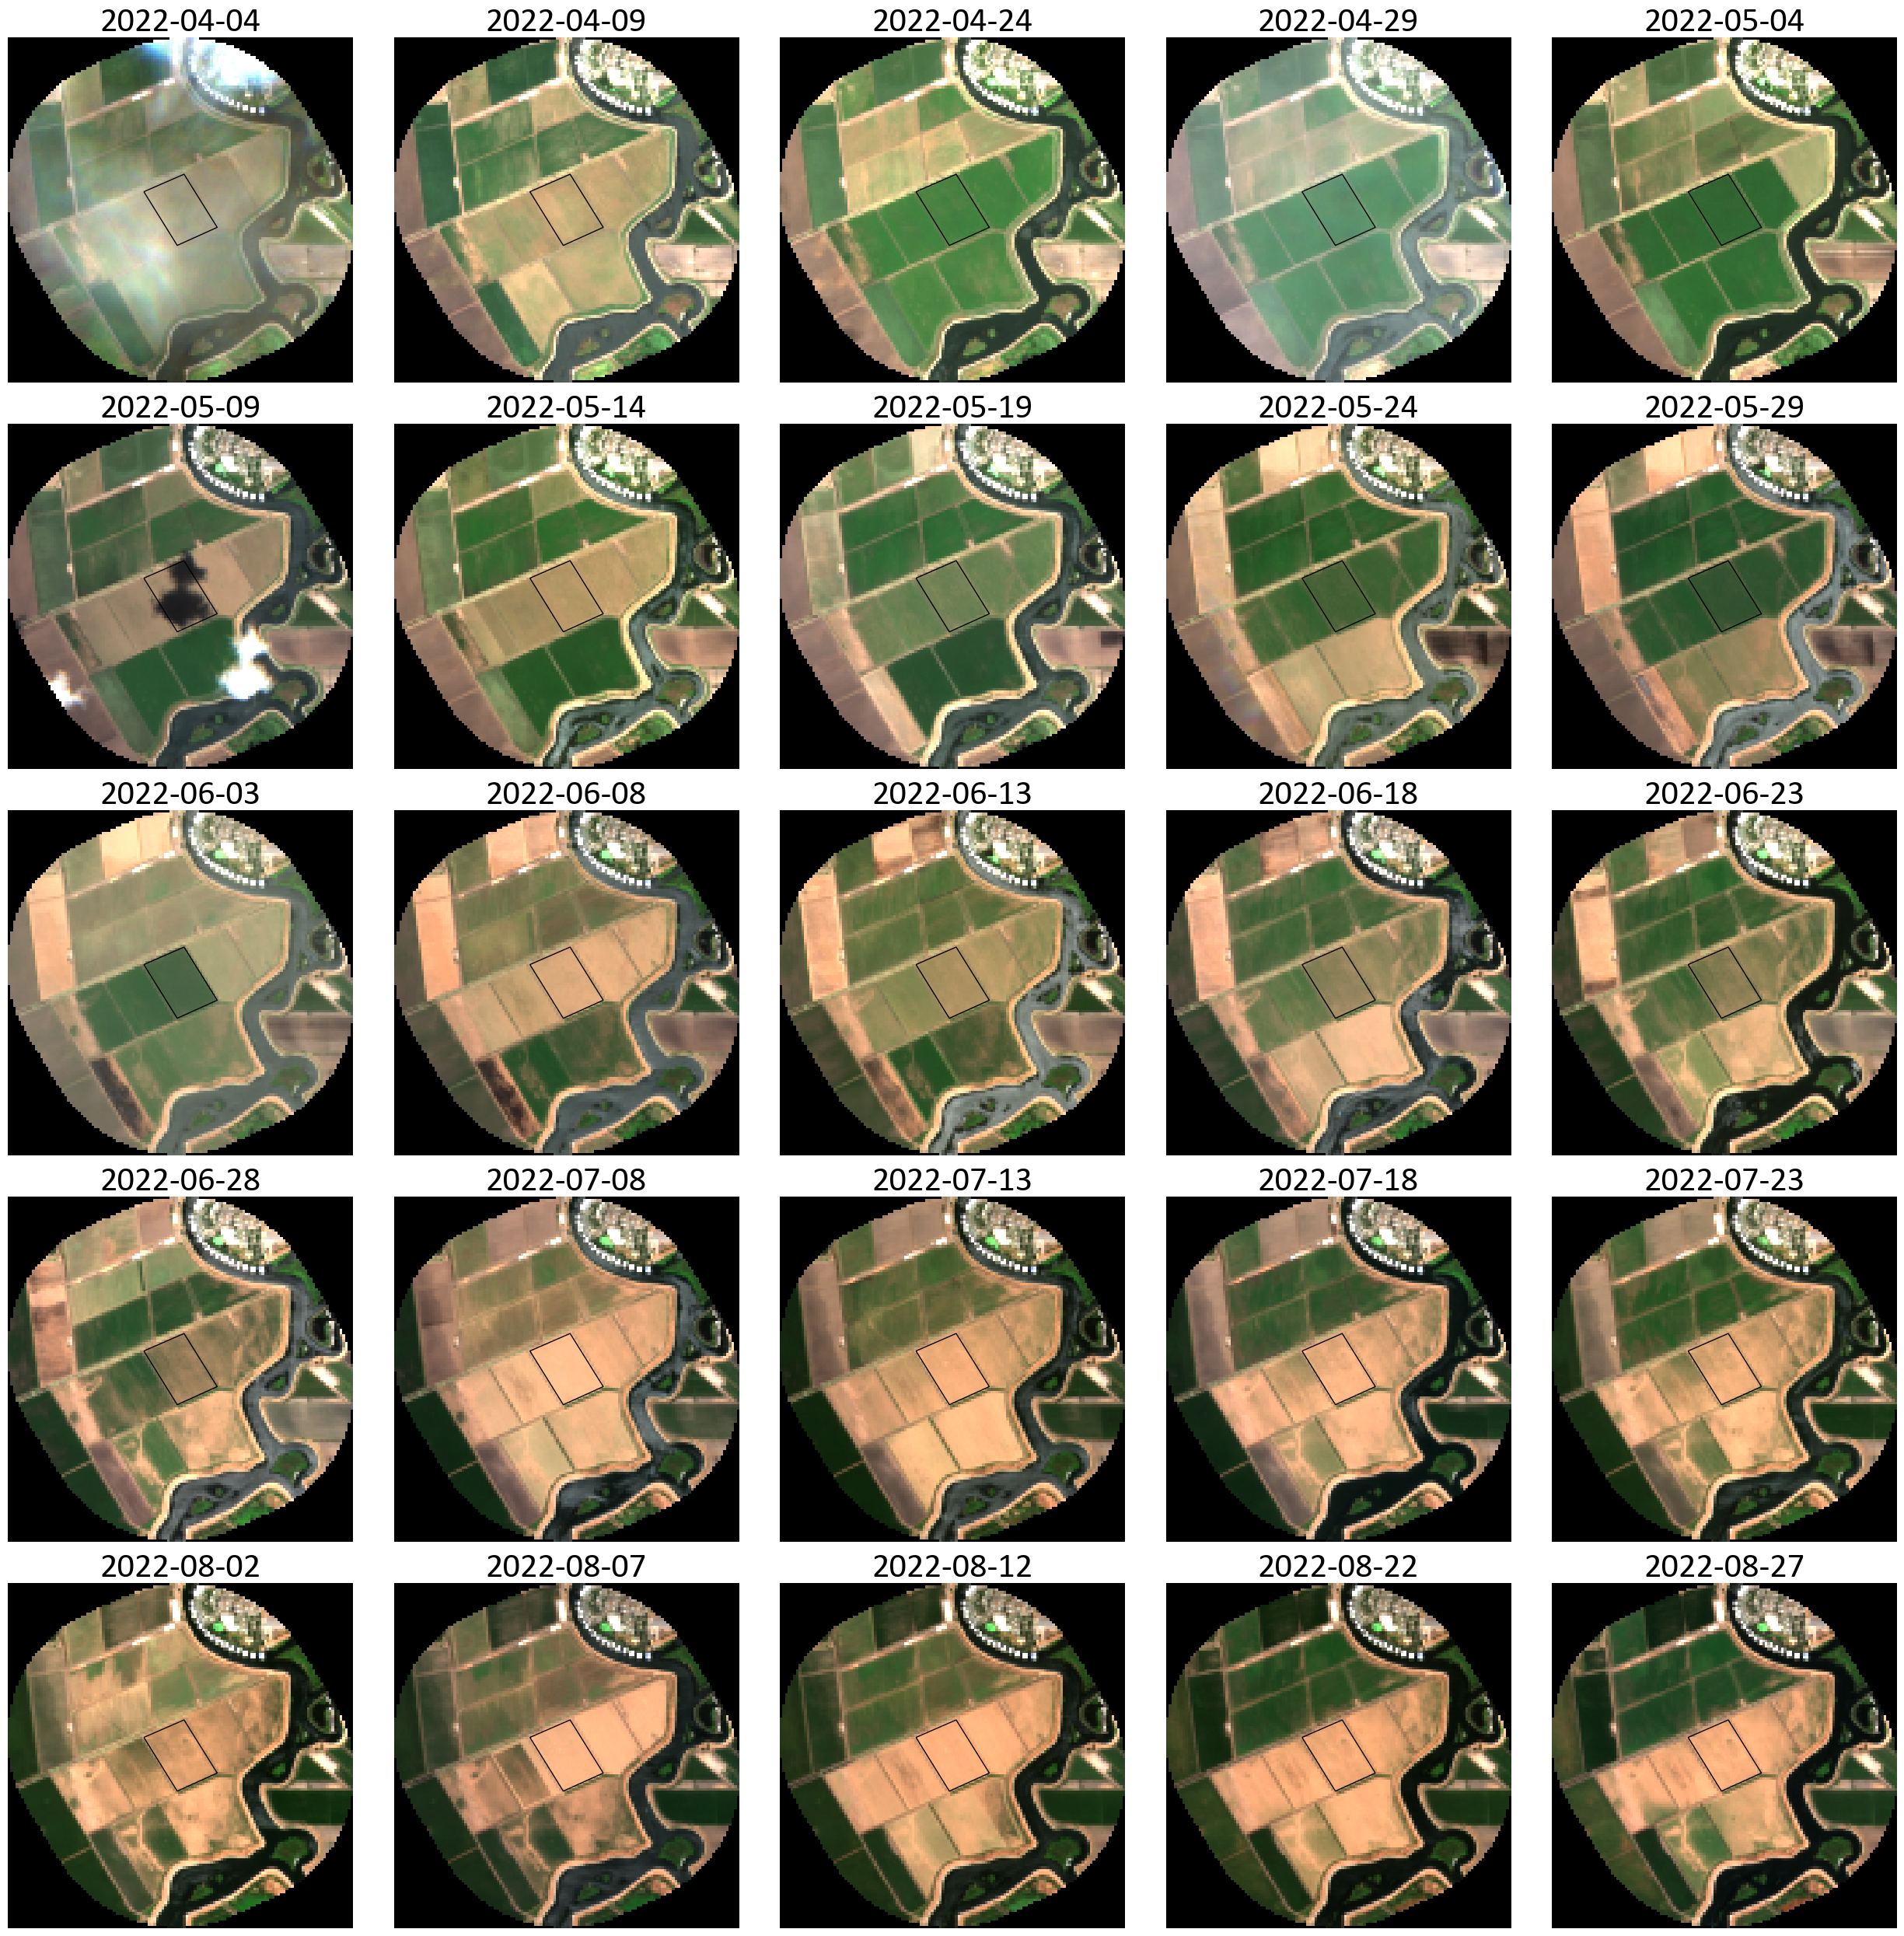

In [22]:
# Plot time series images of Sentinel-2 data
fig, axes = plt.subplots(5,5, figsize=(25,25))
axes = axes.flat

for i, timestamp in enumerate(s2_rgb['time']):
    image = s2_rgb.sel(time=timestamp)
    image.plot.imshow(ax=axes[i], robust=True, rgb='band')
    f1_poly_gdf.plot(ax=axes[i], facecolor='none', edgecolor='black')
    axes[i].set_title(np.datetime_as_string(timestamp.values, unit='D'),
                      fontsize=32)

for ax in axes:
    ax.set_axis_off()
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

<p style="font-size: .9rem"><b>Figure 3 Panel A</b> | A time series of Sentinel-2 true color imagery for the growing season in the year 2022. The imagery illustrates the periodic greening and harvest of an alfalfa field throughout the growing season.</p>

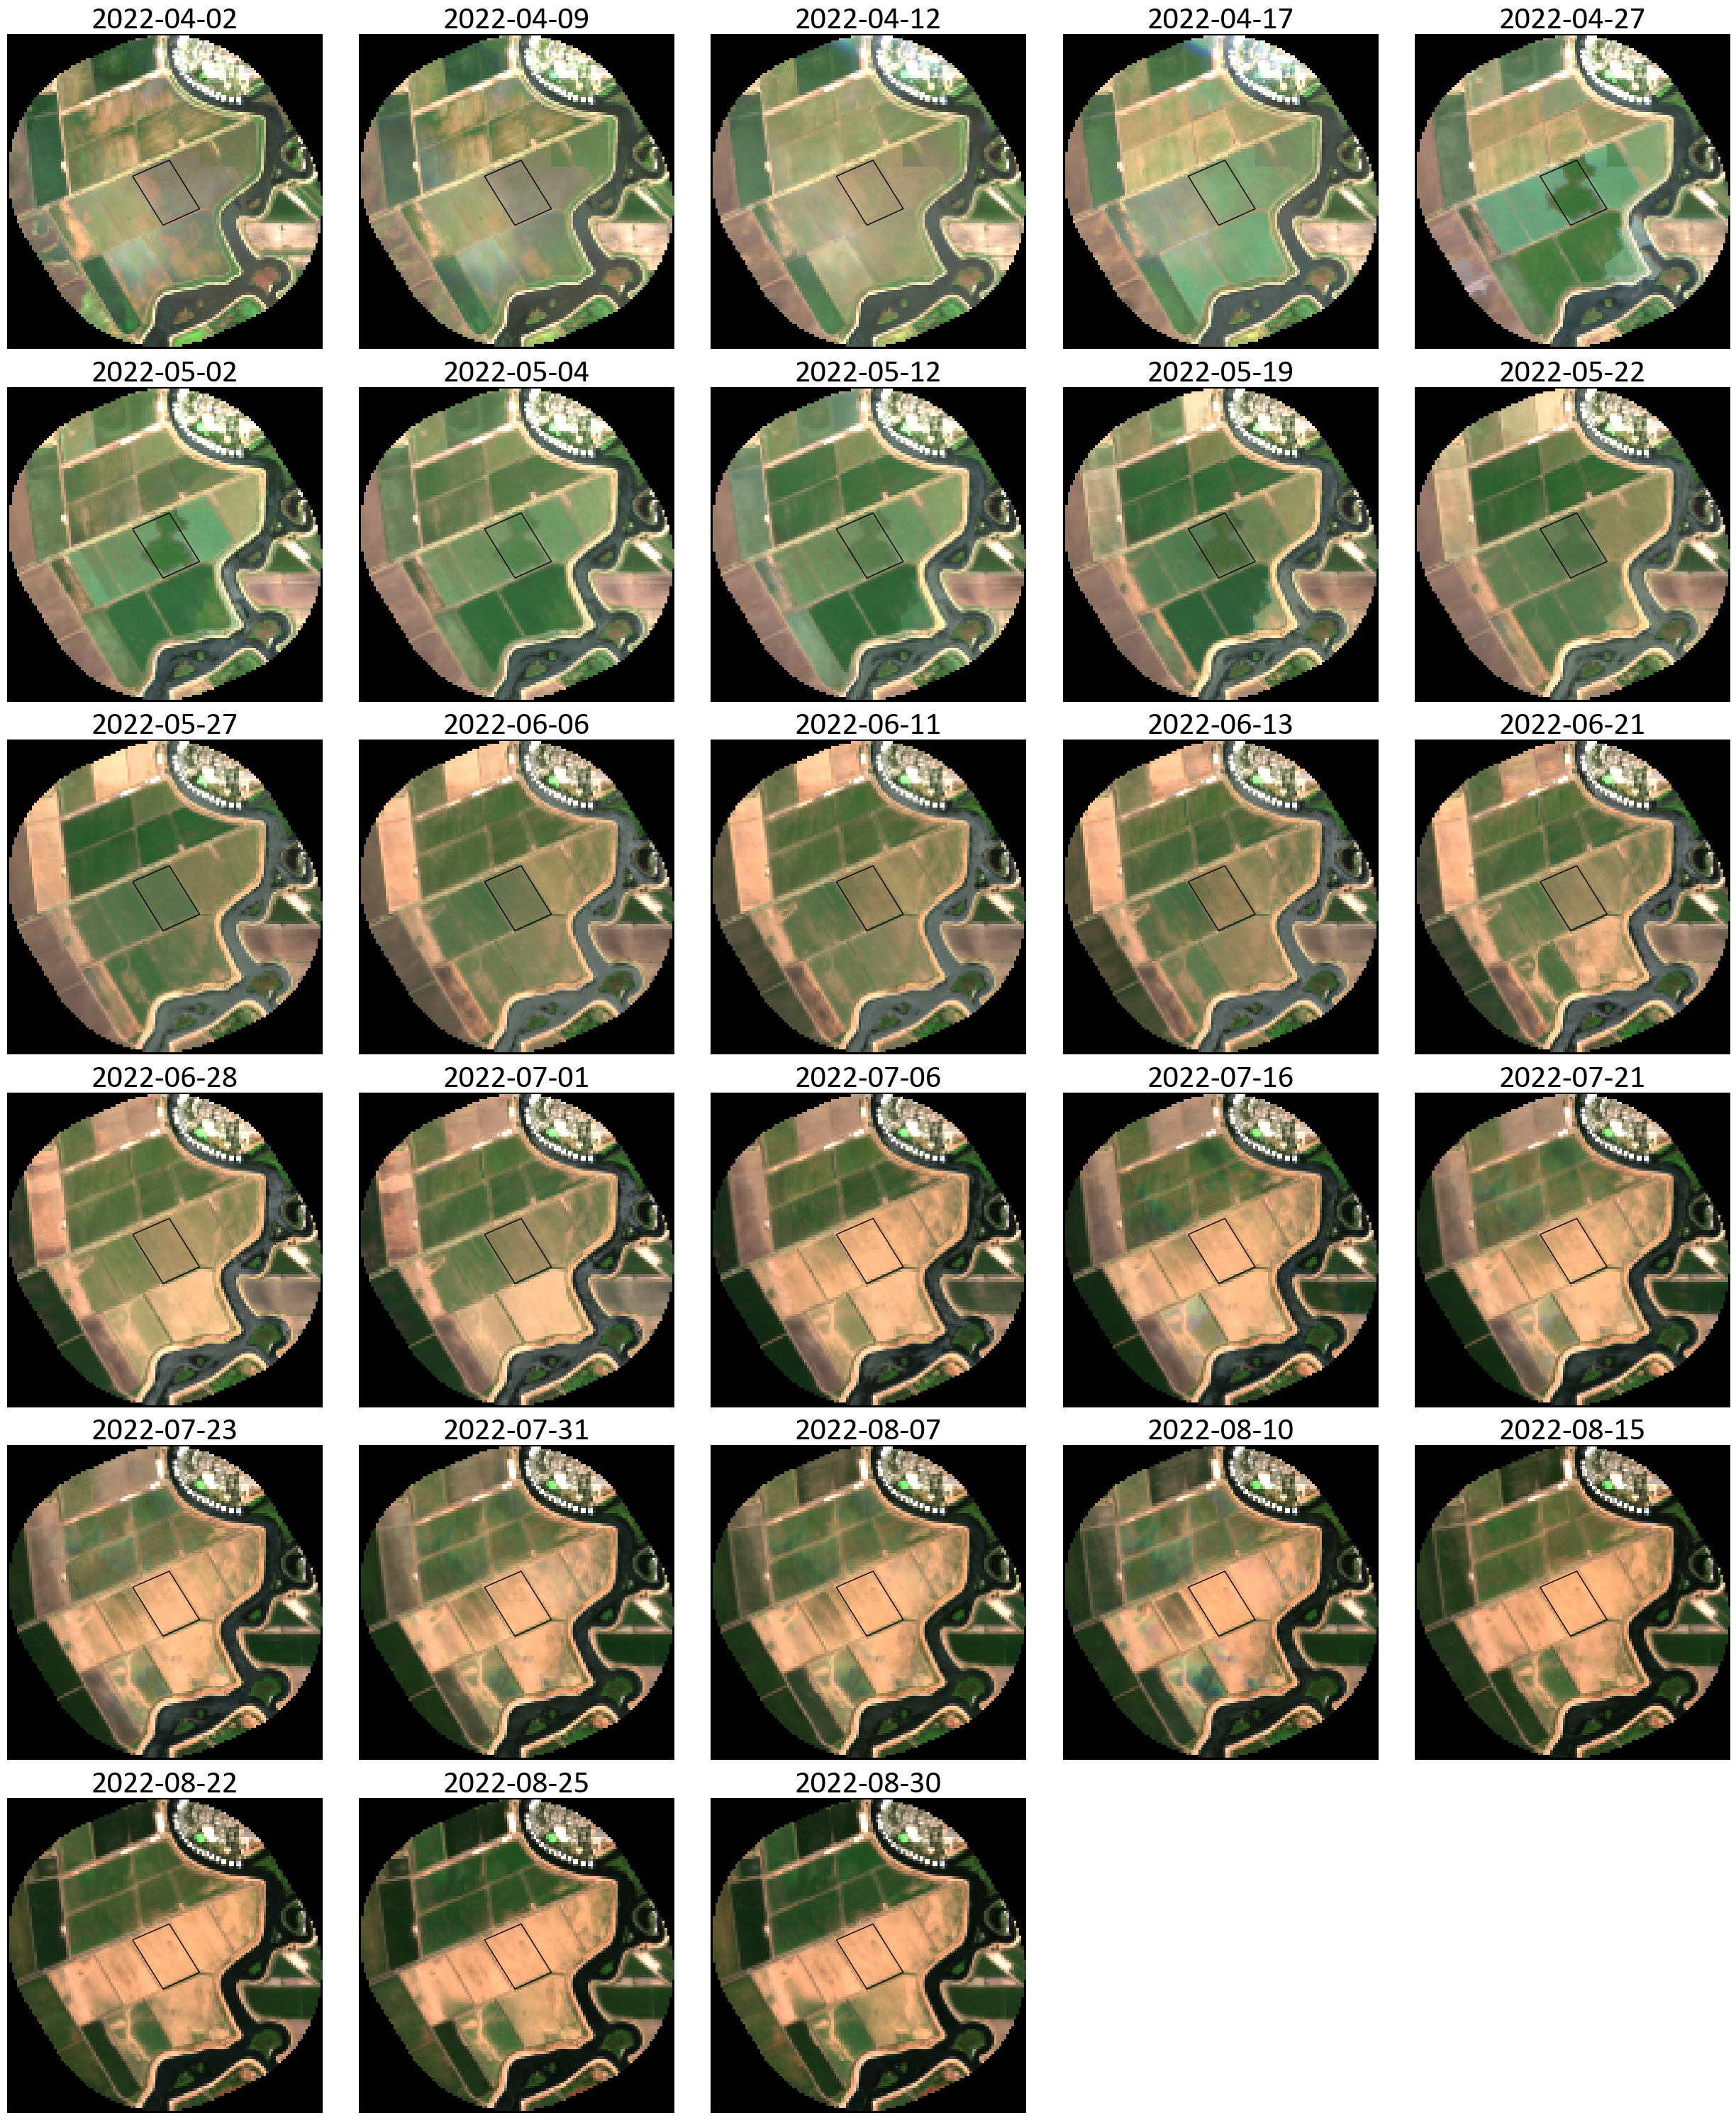

In [23]:
# Plot time series images of Sentinel-2 composite data
fig, axes = plt.subplots(6,5, figsize=(25,30))
axes = axes.flat

for i, timestamp in enumerate(s2_comp_rgb['time']):
    image = s2_comp_rgb.sel(time=timestamp)
    image.plot.imshow(ax=axes[i], robust=True, rgb='band')
    f1_poly_gdf.plot(ax=axes[i], facecolor='none', edgecolor='black')
    axes[i].set_title(np.datetime_as_string(timestamp.values, unit='D'),
                      fontsize=32)

for ax in axes:
    ax.set_axis_off()
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

<p style="font-size: .9rem"><b>Figure 3 Panel B</b> | A time series of Sentinel-2 true color imagery for the growing season in the year 2022. The imagery illustrates the muted vegetation signal caused by compositing the imagery with a moving window approach. The periodic harvest and intermittent dry up of the alfalfa field is hidden.</p>

In the original Sentinel-2 true color imagery, we can observe a periodic greening and drying up of the field. In the Central Valley of California, alfalfa is often harvested across many cuttings each year. The imagery is consistent with this practice and reflects the NDVI measures produced by the meteorological tower on site.

However, the composite Sentinel-2 data shows a more consistent trend from green vegetation to dry soil over the course of the growing season. While this does reflect the general trend for this field, the composite Sentinel-2 data does not capture the periodic nature of this trend and thus will likely miss important cues of crop stress.

## <span style="color:green"> The fused land surface temperature product provides a leading indicator of crop stress. </span>

NDVI index is a lagging indicator of crop stress because water or heat stress occurs prior to the degradation of vegetation greenness. A more timely indicator of crop water stress can be calculated as the difference between the the ambient air temperature and the temperature at the crop canopy, referred to as Canopy Air Temperature Difference or CATD (Erdem 2006). Crop canopy temperature can be measured remotely using thermal infrared imagery and is available in the Fused LST product. A healthy crop will cool the air temperature at its canopy through evapotranspiration. As the crop becomes water stressed or otherwise senscent, transpiration will be reduced and the difference between the ambient air temperature and the crop canopy will approach zero.

In the corn field, a comparison of CATD to NDVI over time indicates the potential for the Fused LST product to provie an earlier indicator of crop water stress relative to NDVI. High values of CATD, which indicate healthy vegetation, are associated with low values of NDVI in the early growing season. As the corn crop matures and halts growth, CATD values quickly fall to near zero even while NDVI remains high. This illustrates the potential for CATD derived from the Fused LST product to provide an early warning signal for crop water stress.  

In [24]:
# Define paths to data
data_dir = os.path.join('data', 'Ameriflux')
file_name = config[f2_met_tower]['data_params']['file_name']
file_path = os.path.join(data_dir, file_name)

# Read data
met_df = utils.read_ameriflux(file_path)

# Filter meteorological data by dates
filt = (
    (met_df.index > start_date) & (met_df.index < end_date)
)
met_df = met_df.loc[filt]

In [25]:
# Extract time series of max daily temperature 
ta = met_df['TA'].groupby(met_df.index.date).max()
ta.index = pd.to_datetime(ta.index)

In [26]:
# Read items in LST collection in the assessment area
clip_boundary = f2_poly_gdf_buffer
f2_lst_clip = utils.read_and_clip_items(
    lst_items, asset, clip_boundary, dims=("y", "x"))

In [27]:
# Calculate CATD for each date
catd_list = []

for date in f2_lst_clip['time']:
    date_indexer = pd.to_datetime(date.values)
    if date_indexer in ta.index:
        temp = ta.loc[date_indexer]
        temp_K = temp + 273.15
        catd_ds = f2_lst_clip.sel(time=date) - temp_K
        catd_list.append(catd_ds)

catd_clip = xr.concat(catd_list, dim='time')
catd_clip = catd_clip.rio.set_crs(CRS.from_epsg(32610))

In [28]:
# Clip CATD from imagery to field boundary
catd_field = catd_clip.rio.clip(
    clip_boundary.geometry, all_touched=True, drop=True)

In [29]:
# Read items in Sentinel 2 collection in the assessment area
s2_comp_clip2 = utils.read_and_clip_items(
    s2_comp_items, 'surface_reflectance', clip_boundary)
# Create NDVI from Sentinel-2 composite data
s2c_ndvi2 = calc_ndvi(s2_comp_clip2, red_band=2, nir_band=6)
s2c_ndvi2 = s2c_ndvi2.rio.set_crs(CRS.from_epsg(32610))
# Clip NDVI from imagery to field boundary
s2c_ndvi_field2 = s2c_ndvi2.rio.clip(
    clip_boundary.geometry, all_touched=True, drop=True)

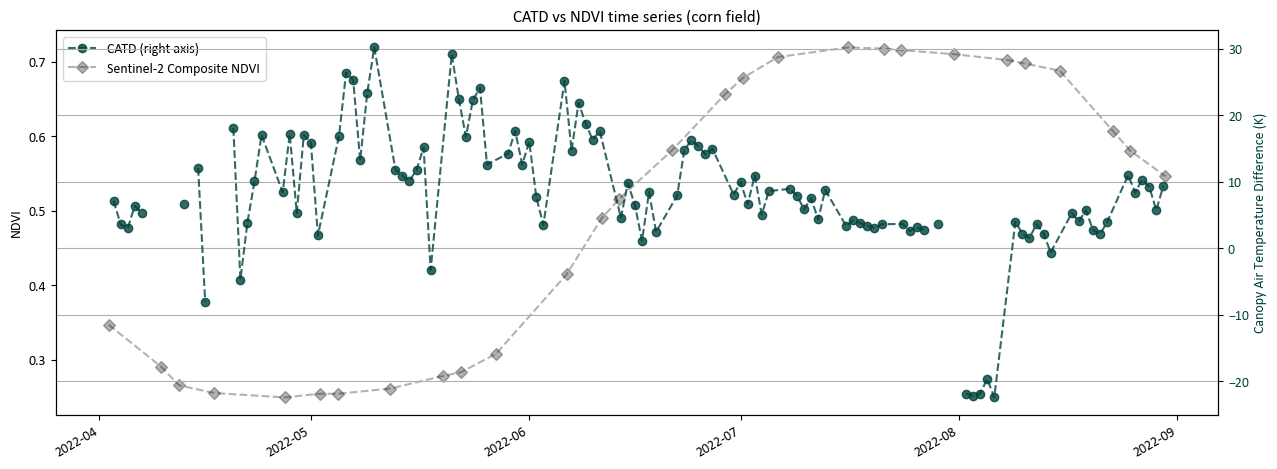

In [30]:
# Plot CATD vs. NDVI series
fig, ax = plt.subplots(figsize=(15,5))
ax2 = ax.twinx()

# Plot data and store lines
line1, = catd_field.mean(dim=('x', 'y')).plot(
    ax=ax2, linestyle='--', alpha=0.8, marker='o', c='#00423c', 
    label='CATD (right axis)')
line2, = s2c_ndvi_field2.mean(dim=('x', 'y')).plot(
    ax=ax, linestyle='--', alpha=0.3, marker='D', c='k', 
    label='Sentinel-2 Composite NDVI')

# Combine legends
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, loc='upper left')

ax2.set_title(f"CATD vs NDVI time series ({f2_met_tower} field)")
ax2.set_xlabel("")
ax2.set_ylabel("Canopy Air Temperature Difference (K)", color='#00423c')
ax2.tick_params(axis='y', labelcolor='#00423c')

ax.set_title("")
ax.set_xlabel("")
ax.set_ylabel("NDVI")

plt.grid(True)
plt.show()


<p style="font-size: .9rem"><b>Figure 4</b> | A time series of the canpopy air temperature difference (CATD) between in-situ air temperature measurements from the meteorological tower and estimated land surface temperature from the fused LST product. A positive CATD is evident in the early growing season while the corn crop is growing. After the corn crop reaches maturity and tranpiration decreases, but well before the NDVI declines, CATD approaches zero which indicates that the crop is no longer growing.</p>

Our analysis indicates that the Fused LST product has significant potential for providing early detection of crop water stress. However, to meet the needs of agricultural producers and detect crop water stress in time for producers to apply supplemental irrigation or take other interventions, adjustments must be made to the algorithm implementations to preserve the short term vegetation signal. 

## <span style="color:green">Collaborators </span>

- [Erik Anderson](https://github.com/eriktuck)
- [Tyler Cruickshank](https://github.com/tcruicks)
- [Joe McGlinchy](https://github.com/joemcglinchy)
We thank Joe McGlinchy of Hydrosat for providing project guidance and data access.

## <span style="color:green">Learn More</span>
Find our repository on GitHub [here](https://github.com/eriktuck/lst-crop-stress-capstone). You can customize this workflow by selecting an alternative crop field from the `config.yml` file or add your own.

## <span style="color:green">References</span>

Y. Erdem , T. Erdem , A.H. Orta & H. Okursoy. Canopy-air temperature differential for potato under different irrigation regimes. Acta Agriculturae Scandinavica Section B-Soil and Plant Science, 2006; 56: 206216

Gao, F. Masek, J. Schwaller, M. Hall, F. 2006. On the Blending of Landsat and MODIS Surface Reflectance: Predicting Landsat Surface Reflectance. IEE Transaction on Geoscience and Remote Sensing Vol 44, No 8.

Gao, F. Kustas, W. Anderson, M. 2012. A Data Mining Approach for Sharpening Thermal Satellite Imagery Over Land. Remote Sensing. doi: 10.3390/rs4113287.